# DSCI 100 Project: Individual planning stage

**By Angel Chen (71703029) of Group 4 from DSCI 100 – section 008**

In [30]:
library(repr)
library(tidyverse)
library(cowplot)
library(lubridate)
options(scipen = 999, repr.matrix.max.rows = 4)

In [54]:
# All the code in this notebook are congregated at the beginning to ease later readability
# when swapping between code and markdown cells.
# These datasets and figures will be called later when appropriate.

# Loading the datasets into this notebook.
og_players <- read_csv("data/players.csv", show_col_types = FALSE)
og_sessions <- read_csv("data/sessions.csv", show_col_types = FALSE)

# Wrangling to tidy the data (correcting the data types).
players <- og_players |>
    mutate(
        experience = as_factor(experience),
        gender = as_factor(gender)
    )
sessions <- og_sessions |>
    mutate(
        start_time = as.POSIXct(start_time, format = "%d/%m/%Y %H:%M", tz = "GMT"),
        end_time = as.POSIXct(end_time, format = "%d/%m/%Y %H:%M", tz = "GMT")
    )

# Plots!


The questions:
> Question 1: What player characteristics and behaviours are most predictive of subscribing to a game-related newsletter, and how do these features differ between various player types?
> 
> Question 2: We would like to know which "kinds" of players are most likely to contribute a large amount of data so that we can target those players in our recruiting efforts.
> 
> Question 3: We are interested in demand forecasting, namely, what time windows are most likely to have large number of simultaneous players. This is because we need to ensure that the number of licenses on hand is sufficiently large to accommodate all parallel players with high probability. 

Let's first have a look at the data.

In [3]:
og_players

experience subscribe
1   Pro        TRUE     
2   Veteran    TRUE     
⋮   ⋮          ⋮        
195 Amateur    FALSE    
196 Pro         TRUE    
    hashedEmail                                                     
1   f6daba428a5e19a3d47574858c13550499be23603422e6a0ee9728f8b53e192d
2   f3c813577c458ba0dfef80996f8f32c93b6e8af1fa939732842f2312358a88e9
⋮   ⋮                                                               
195 f19e136ddde68f365afc860c725ccff54307dedd13968e896a9f890c40aea436
196 d9473710057f7d42f36570f0be83817a4eea614029ff90cf50d8889cdd729d11
    played_hours name      gender Age
1   30.3         Morgan    Male    9 
2    3.8         Christian Male   17 
⋮   ⋮            ⋮         ⋮      ⋮  
195 2.3          Harlow    Male   17 
196 0.2          Ahmed     Other  NA

Within the `players` dataset, we can see certain characteristics of each participant who has signed up to PLAICraft.ai. There are 196 observations and 7 variables. The variables are summarized by the following table:

|Variable|Data type|Explanation|
|--------|--------|--------|
|`experience`|character|Player's self-identified Minecraft experience level|
|`subscribe`|logical|Player's subscription to newsletter (true if subscribed)|
|`hashedEmail`|character|Player's email address hidden as a hash|
|`played_hours`|double|Total hours of Minecraft played via the plaicraft.ai server|
|`name`|character|Player's submitted name|
|`gender`|character|Player's self-identified gender|
|`Age`|double|Player's submitted age|

From the get-go, we can see that certain variables' data types aren't optimal. Namely, for categorical variables with a limited selection of values like `experience` and `gender`, the data type should be changed to factor.

In [4]:
players

experience subscribe
1   Pro        TRUE     
2   Veteran    TRUE     
⋮   ⋮          ⋮        
195 Amateur    FALSE    
196 Pro         TRUE    
    hashedEmail                                                     
1   f6daba428a5e19a3d47574858c13550499be23603422e6a0ee9728f8b53e192d
2   f3c813577c458ba0dfef80996f8f32c93b6e8af1fa939732842f2312358a88e9
⋮   ⋮                                                               
195 f19e136ddde68f365afc860c725ccff54307dedd13968e896a9f890c40aea436
196 d9473710057f7d42f36570f0be83817a4eea614029ff90cf50d8889cdd729d11
    played_hours name      gender Age
1   30.3         Morgan    Male    9 
2    3.8         Christian Male   17 
⋮   ⋮            ⋮         ⋮      ⋮  
195 2.3          Harlow    Male   17 
196 0.2          Ahmed     Other  NA

Done! Let's do a summary overview of the data.

In [5]:
summary(players) # <- will probably put this at the end

    experience subscribe       hashedEmail         played_hours    
 Pro     :14   Mode :logical   Length:196         Min.   :  0.000  
 Veteran :48   FALSE:52        Class :character   1st Qu.:  0.000  
 Amateur :63   TRUE :144       Mode  :character   Median :  0.100  
 Regular :36                                      Mean   :  5.846  
 Beginner:35                                      3rd Qu.:  0.600  
                                                  Max.   :223.100  
                                                                   
     name                         gender         Age       
 Length:196         Male             :124   Min.   : 9.00  
 Class :character   Female           : 37   1st Qu.:17.00  
 Mode  :character   Non-binary       : 15   Median :19.00  
                    Prefer not to say: 11   Mean   :21.14  
                    Agender          :  2   3rd Qu.:22.75  
                    Two-Spirited     :  6   Max.   :58.00  
                    Other           

Concerning the quantitative variables in `players`,

|Variable|Range (min. to max. value)|Median|Mean|
|--------|--------|--------|--------|
|`played_hours`|0.00 to 223.10|0.10|5.85|
|`Age`|9 to 58|19|21.13|

Within the `Age` variable, there are also 2 `NA`'s, which we will need to account for in our downstream data analysis. It is concerning that the median played hours is 0.10, which reveals that half of players who have signed up to PLAICraft.ai have played less than 0.10 hours. As the dataset includes all participants who have signed up but not necessarily played, players who have `played_hours` values of 0 may not be useful to our analysis if we want to answer Questions 2 or 3.

Concerning the non-quantitative variables,
* `experience` Experience levels have the options ranging from Beginner, Amateur, Regular, Veteran, Pro. From reading the blog on PLAICraft.ai, we learn that these experience levels are self-identified by the participants. The problem, however, is that this variable is clearly an ordinal categorical variable, but there is no indication from the researcher's site concerning the order of experience level. Is "Veteran" more experienced than "Pro"? We do not know.
* `subscribe` In this variable, the value is `TRUE` if the participant has subscribed to a game-related newsletter, `FALSE` otherwise. However, we have no information on what this newsletter is. Is this newsletter provided by the research team? Is it related to PLAICraft.ai and Minecraft content, or is it about video games in general? We also do not know if this is self-reported from the participants or data from the researchers. If it is the latter, then the newsletter is provided by the research team.
* `hashedEmail` The 64-digit hash of the players' emails includes a unique and random combination and order of arabic numbers and alphabetical letters.
* `name` The player's submitted name for researchers to refer to them with more ease rather than a bunch of hashes. Players can also see each other's names in-game to facilitate easy communication.
* `gender` The self-identified gender is limited to the options of Male, Female, Non-binary, Agender, Two-Spirited, Other, and Prefer not to say.

Now, let's have a look at the other dataset.

In [6]:
og_sessions

hashedEmail                                                     
1    bfce39c89d6549f2bb94d8064d3ce69dc3d7e72b38f431d8aa0c4bf95ccee6bf
2    36d9cbb4c6bc0c1a6911436d2da0d09ec625e43e6552f575d4acc9cf487c4686
⋮    ⋮                                                               
1534 fd6563a4e0f6f4273580e5fedbd8dda64990447aea5a33cbb5e894a3867ca44d
1535 36d9cbb4c6bc0c1a6911436d2da0d09ec625e43e6552f575d4acc9cf487c4686
     start_time       end_time         original_start_time original_end_time
1    30/06/2024 18:12 30/06/2024 18:24 1719770000000       1719770000000    
2    17/06/2024 23:33 17/06/2024 23:46 1718670000000       1718670000000    
⋮    ⋮                ⋮                ⋮                   ⋮                
1534 25/07/2024 06:15 25/07/2024 06:22 1721890000000       1721890000000    
1535 20/05/2024 02:26 20/05/2024 02:45 1716170000000       1716170000000

Within the `sessions` dataset, each observation (row) is an instance of a participant's uninterrupted Minecraft gaming session on PLAICraft.ai. Players are identified by their unique `hashedEmail`, and players who play on PLAICraft.ai for more than one session would have more than one observation in this dataset.

|Variable|Data type|Explanation
|--------|--------|--------|
|`hashedEmail`|character|Player's email address hidden as a 64-digit hash|
|`start_time`|double|GMT dd/mm/yyyy and 24-hour time at which player began playing session|
|`end_time`|double|GMT dd/mm/yyyy and 24-hourtime at which player ended playing session|
|`original_start_time`|double|GMT Unix timestamp at which player began playing session|
|`original_end_time`|double|GMT Unix timestamp at which player ended playing session|

The Unix Epoch timestamps include milliseconds (therefore 13 digits) and is in GMT. The same goes for `start_time` and `end_time`. A primary concern with the `original_start_time` and `original_end_time` variables is that the last 7 digits are omitted (written as 0). The last 3 digits represent the milliseconds, which do not matter. However, the preceding 4 digits represent the minutes and hours (one hour is 3600 seconds). The fact that these digits are omitted to 0 means that we will not see any change in the Unix timestamp between `original_start_time` and `original_end_time` unless the uninterrupted gaming session exceeds 24 hours, which did not occur in this dataset. These two variables are therefore not useful for downstream application.

For ease of use with `start_time` and `end_time`, the data type will be changed from character to datetime.

In [7]:
#sessions1 <- sessions |>
#    separate(
#        start_time, c("start_date", "start_time"), sep = " "
#    ) |>
#    mutate(
#        start_date = as.POSIXct(start_date, format = "%d/%m/%Y", tz = "GMT"),
#        start_time = as.POSIXct(start_time, format = "%H:%M", tz = "GMT"),
#        end_time = as.POSIXct(end_time, format = "%d/%m/%Y %H:%M", tz = "GMT")
#    )

# IF ANY OF THE DTTM VARIABLES RETURN `NA`, PLEASE RESTART KERNEL AND RERUN THE CELLS.
#as.POSIXlt("30/06/2024 18:24", format = "%d/%m/%Y %H:%M", tz = "GMT")

# POSIXct stores stuff in chronological order according to UNIX time
# I want POSIXlt because I want to graph the hours irregardless of the date...
# But ggplot works much better with POSIXct...

# Unless I just convert the hours to decimals rather than H:M
sessions

hashedEmail                                                     
1    bfce39c89d6549f2bb94d8064d3ce69dc3d7e72b38f431d8aa0c4bf95ccee6bf
2    36d9cbb4c6bc0c1a6911436d2da0d09ec625e43e6552f575d4acc9cf487c4686
⋮    ⋮                                                               
1534 fd6563a4e0f6f4273580e5fedbd8dda64990447aea5a33cbb5e894a3867ca44d
1535 36d9cbb4c6bc0c1a6911436d2da0d09ec625e43e6552f575d4acc9cf487c4686
     start_time          end_time            original_start_time
1    2024-06-30 18:12:00 2024-06-30 18:24:00 1719770000000      
2    2024-06-17 23:33:00 2024-06-17 23:46:00 1718670000000      
⋮    ⋮                   ⋮                   ⋮                  
1534 2024-07-25 06:15:00 2024-07-25 06:22:00 1721890000000      
1535 2024-05-20 02:26:00 2024-05-20 02:45:00 1716170000000      
     original_end_time
1    1719770000000    
2    1718670000000    
⋮    ⋮                
1534 1721890000000    
1535 1716170000000

In [8]:
#sessions2 <- sessions |>
#    separate(start_time, c("start_date", "start_time"), sep = " ") |>    
#    separate(start_time, c("hour", "minute"), sep = ":")

#sessions3 <- sessions2 |>
#    mutate(minute = as.double(minute)) |>
#    mutate(minute = minute / 60) |>
#    mutate(hour = as.double(hour)) |>
#    mutate(hour_decimal = hour + minute) |>
#    select(-hour, -minute)
    #transform(hour_decimal = paste0(hour, minute)) NVM I'M JUST SUPPOSED TO ADD THEM LMAOOOOOO
#sessions3

#arrange(sessions3, desc(hour_decimal))
#filter(sessions3, hour_decimal == 0)

In [9]:
summary(sessions)

 hashedEmail          start_time                    
 Length:1535        Min.   :2024-04-06 09:27:00.00  
 Class :character   1st Qu.:2024-05-20 20:28:00.00  
 Mode  :character   Median :2024-06-24 02:51:00.00  
                    Mean   :2024-06-24 03:54:03.51  
                    3rd Qu.:2024-07-25 06:56:00.00  
                    Max.   :2024-09-26 06:09:00.00  
                                                    
    end_time                      original_start_time    
 Min.   :2024-04-06 09:31:00.00   Min.   :1712400000000  
 1st Qu.:2024-05-20 21:37:00.00   1st Qu.:1716240000000  
 Median :2024-06-23 22:04:00.00   Median :1719200000000  
 Mean   :2024-06-24 02:26:18.03   Mean   :1719201355050  
 3rd Qu.:2024-07-25 07:00:00.00   3rd Qu.:1721890000000  
 Max.   :2024-09-26 07:39:00.00   Max.   :1727330000000  
 NA's   :2                                               
 original_end_time      
 Min.   :1712400000000  
 1st Qu.:1716240000000  
 Median :1719180000000  
 Mean   :171

We also see there are 2 `NA`'s within

In [10]:
players_summary <- players |>
    summarize(
        mean_played_hours = mean(played_hours),
        mean_age = mean(Age, na.rm = TRUE)
        )
players_summary

mean_played_hours mean_age
1 5.845918          21.13918

### Research question: Figuring out time windows with peak player activity
### What time of day are players the most active on PLAICraft.ai? Specific question: What are the demographics (age, gender, experience level) of these players? Can we predict the time of day a player is most likely to start a session on PLAICraft.ai based on their age, gender, and experience level?

How I'll go about answering this question:
* Remove players that have 0h playtime from `players.csv`
* First plot a histogram of the hours of the day that players are most frequent to start playing sessions
* Players that have >1 sessions, the time at which they start will be averaged, so each player would only have 1 entry
* And then combine the 2 datasets for predictive analysis

In [11]:
colSums(is.na(sessions))
filter(sessions, is.na(end_time))

hashedEmail          start_time            end_time original_start_time 
                  0                   0                   2                   0 
  original_end_time 
                  2

hashedEmail                                                     
1 55d24216db39c27e1f17cc43d3127cbf8ed76ada6d098202b53ded319855e2c1
2 b622593d2ef8b337dc554acb307d04a88114f2bf453b18fb5d2c80052aeb2319
  start_time          end_time original_start_time original_end_time
1 2024-08-27 17:06:00 <NA>     1724780000000       NA               
2 2024-09-15 04:21:00 <NA>     1726370000000       NA

In [12]:
colSums(is.na(players))
filter(players, is.na(Age))

experience    subscribe  hashedEmail played_hours         name       gender 
           0            0            0            0            0            0 
         Age 
           2

experience subscribe
1 Regular    TRUE     
2 Pro        TRUE     
  hashedEmail                                                      played_hours
1 7d71c49cbbce8dcf0276b2bfecfa2d16f22cb31a4024556d6085884298f2ee8d 0.1         
2 d9473710057f7d42f36570f0be83817a4eea614029ff90cf50d8889cdd729d11 0.2         
  name  gender       Age
1 Devin Two-Spirited NA 
2 Ahmed Other        NA

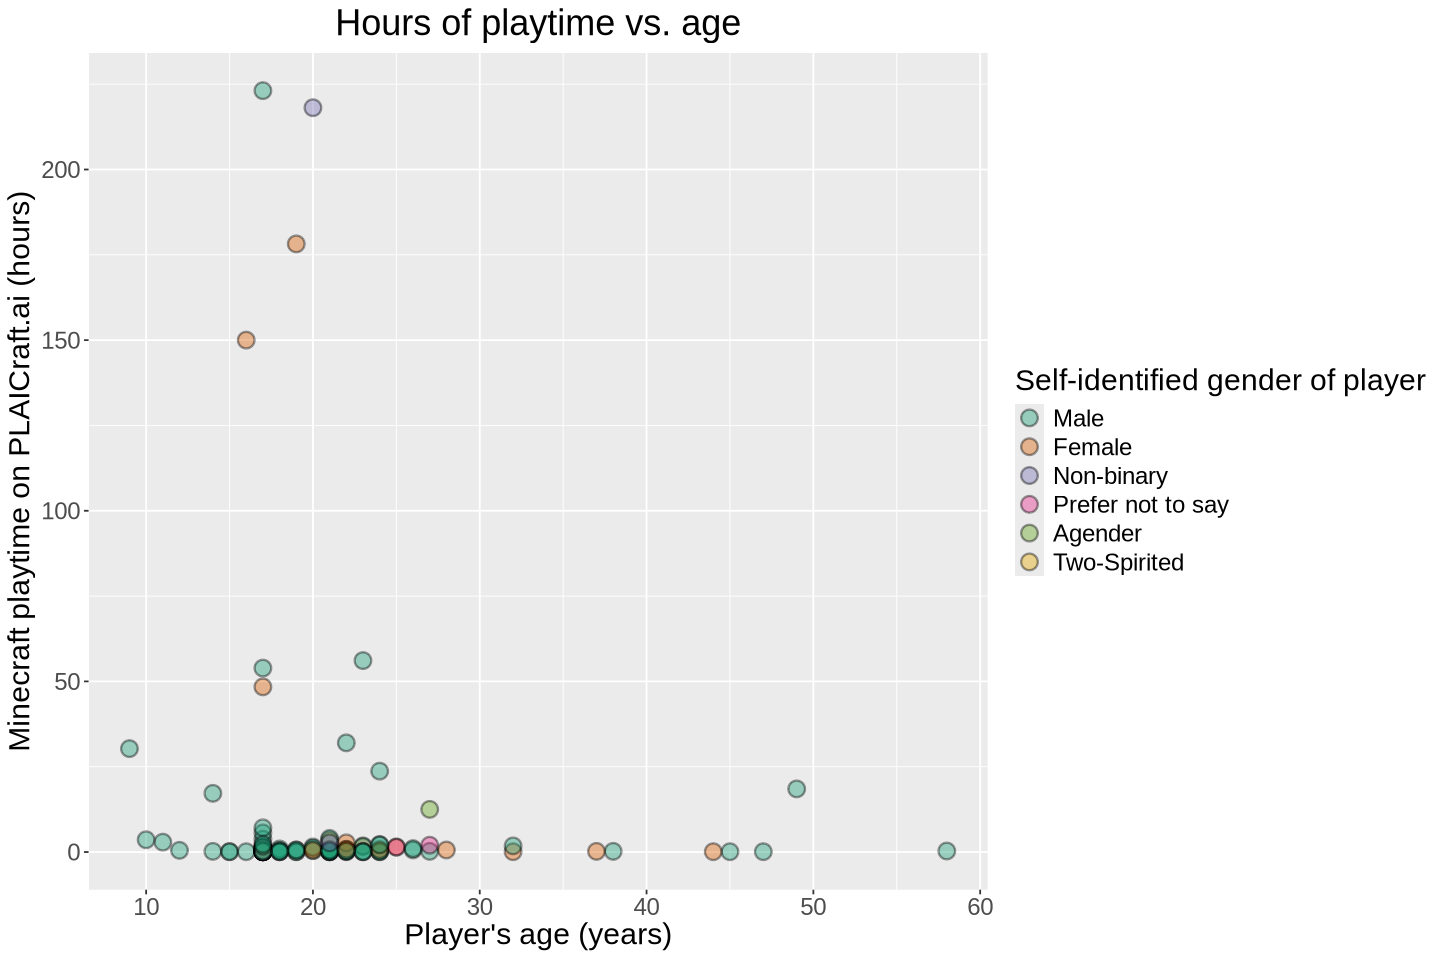

In [13]:
options(repr.plot.width = 12, repr.plot.height = 8)
dark2_palette <- c("#1B9E77FF", "#D95F02FF", "#7570B3FF", "#E7298AFF", "#66A61EFF", "#E6AB02FF", "#A6761DFF", "#666666FF")

hour_v_age <- na.omit(players) |> #There are 2 players with NA age
    filter(played_hours != 0) |>
    ggplot(aes(x = Age, y = played_hours, fill = gender)) +
        geom_point(alpha = 0.4, size = 4, stroke = 1, shape = 21) +
        labs(x = "Player's age (years)", y = "Minecraft playtime on PLAICraft.ai (hours)",
             fill = "Self-identified gender of player", title = "Hours of playtime vs. age") +
        theme(text = element_text(size = 18), plot.title = element_text(hjust = 0.5)) +
        scale_fill_brewer(palette = "Dark2") +
        scale_colour_brewer(palette = "Dark2")
hour_v_age


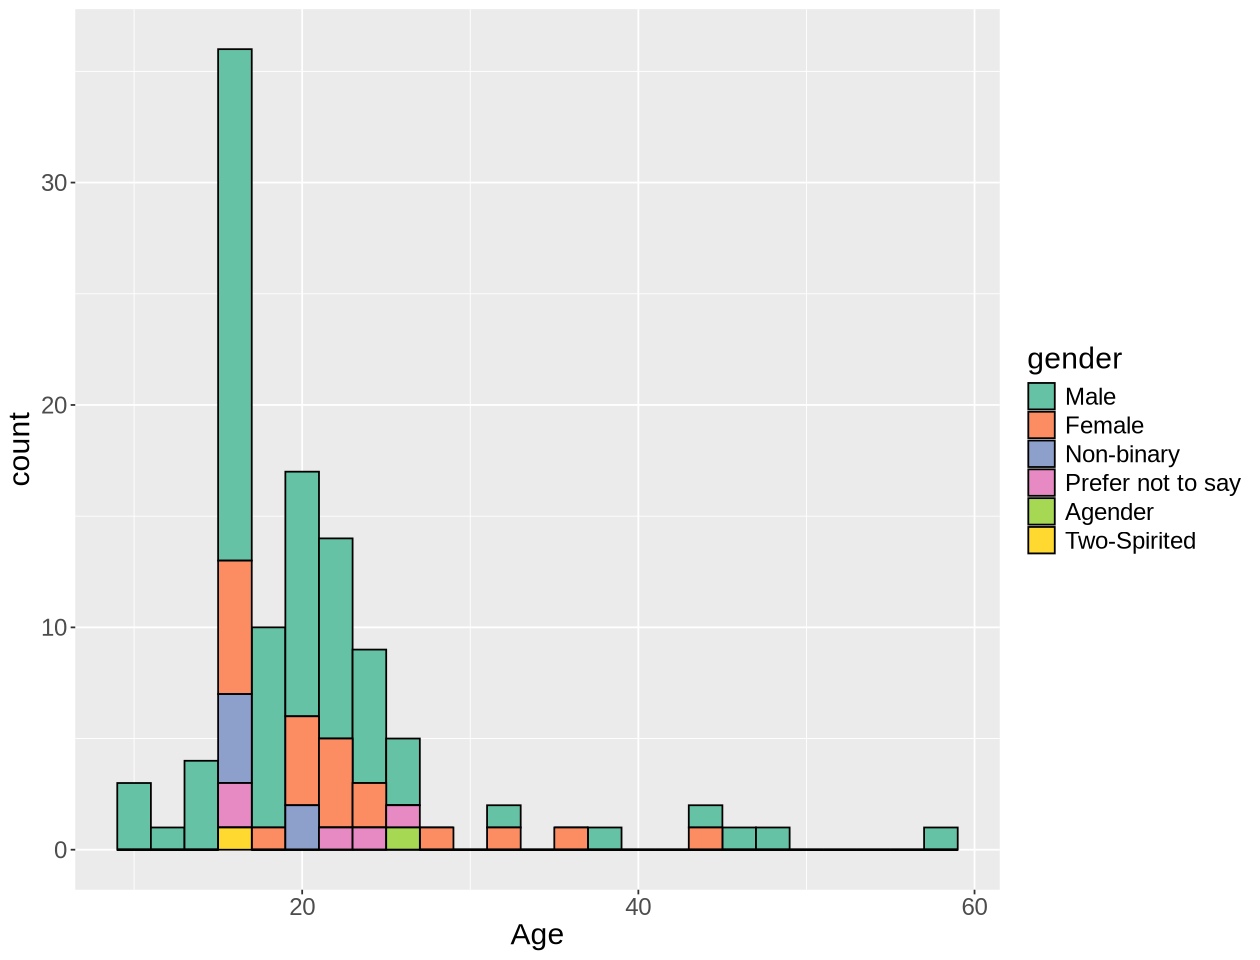

In [14]:
options(repr.plot.width = 10.5, repr.plot.height = 8)
player_age <- players |>
    na.omit() |>
    filter(played_hours > 0) |>
    ggplot(aes(Age, fill = gender)) +
        geom_histogram(binwidth = 2, colour = "black") +
        labs() +
        theme(text = element_text(size = 18), plot.title = element_text(hjust = 0.5)) +
        scale_fill_brewer(palette = "Set2")
player_age

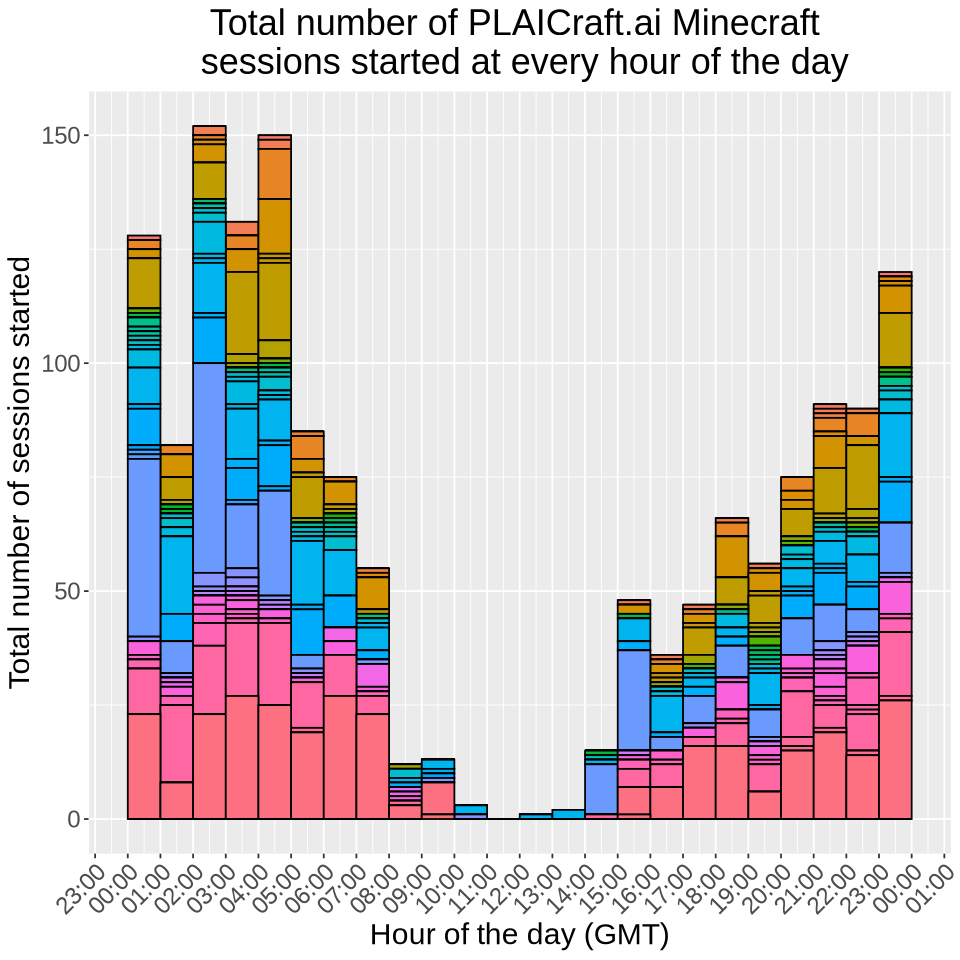

In [52]:
sessions_start_TEST <- sessions |>
    na.omit() |> # Omit the NA's.
    mutate(start_time_only = strftime(start_time, "%H:%M:%S")) |>
    mutate(start_time_only = as.POSIXct(start_time_only, format = "%H:%M:%S", tz = "GMT")) |>
    ggplot(aes(start_time_only, fill = hashedEmail)) +
        geom_histogram(colour = "black", binwidth = 3600, boundary = 0) +
        scale_x_datetime(date_break = "1 hour", date_label = "%H:%M") +
        labs(x = "Hour of the day (GMT)", y = "Total number of sessions started",
             title = "Total number of PLAICraft.ai Minecraft \n sessions started at every hour of the day") +
        theme(text = element_text(size = 18), plot.title = element_text(hjust = 0.5),
              axis.text.x = element_text(angle = 45, hjust = 1), legend.position = "none")
sessions_start_TEST

# DAMN TS NEEDS 125 COLOURS

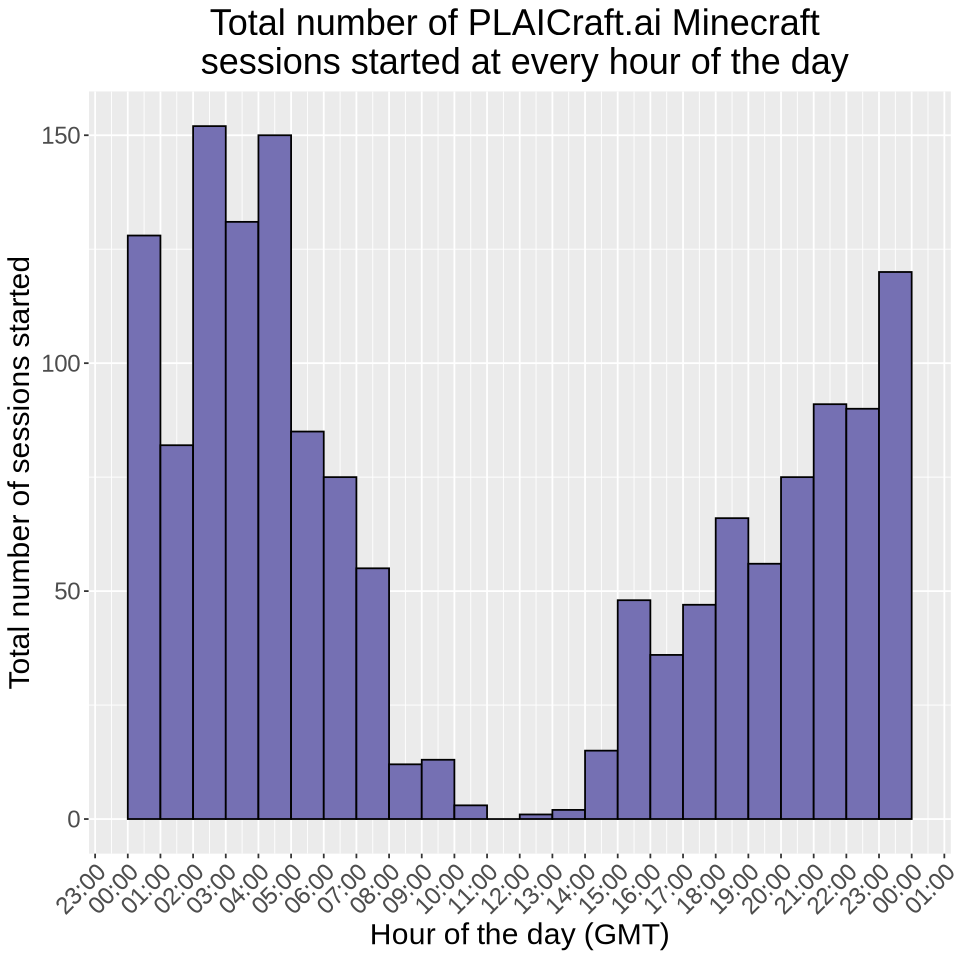

In [56]:
options(repr.plot.width = 8, repr.plot.height = 8)
# Finding the time of day with the most session starts
sessions_start <- sessions |>
    na.omit() |> # Omit the NA's.
    mutate(start_time_only = strftime(start_time, "%H:%M:%S")) |> # Extract time from start_time without date, attach as new column.
    mutate(start_time_only = as.POSIXct(start_time_only, format = "%H:%M:%S", tz = "GMT")) |> # Change type from chr to POSIXct dttm.
    ggplot(aes(start_time_only)) + # Now, the data can be plotted.
        geom_histogram(colour = "black", binwidth = 3600,
                       boundary = 0, fill = "#7570b3ff") +
        scale_x_datetime(date_break = "1 hour", date_label = "%H:%M") +
        labs(x = "Hour of the day (GMT)", y = "Total number of sessions started",
             title = "Total number of PLAICraft.ai Minecraft \n sessions started at every hour of the day") +
        theme(text = element_text(size = 18), plot.title = element_text(hjust = 0.5),
              axis.text.x = element_text(angle = 45, hjust = 1))
sessions_start


# MAIN PROBLEM WITH THIS DATA IS THAT -> Players with high play hours (contribute a lot of data) may have the same habits of starting
# the game at around the same time everyday. This graph includes all session starts, regardless if it's on a different day or
# from the same player. So players who have played many hours and also start the session at the same time everyday would
# skew the data in their favour (towards THEIR hours).
# SOLUTION: REMOVE DATA FROM REPEAT PLAYERS WHO STARTED SESSION IN THE SAME HOUR? (so it's ok to have multiple sessions
# if they all start in different hours -- will be treated like individual entries -- but if the same player starts the session
# in the same hour >once, then it will be reduced to once... Is this even allowed

# With the sessions_start data -> then calculate average playtime (30 min to 1h?) -> so during that time period, need more servers




# What if I scale the weight like... -> If the player has 8 entries, then each "count" is 1/8 -> to make sure each player's data has the same weight
# In this case, the graph would be coded as a barplot (because the "counts" are inputted manually) disguised as a histogram.

# so do that and then also --> find average duration of a gaming session so researchers can known how long that window is after session start
# prob has to be rescaled/reweighed again so each player's weight = 1

[1] 125

Warning message in as_grob.default(plot):
“Cannot convert object of class numeric into a grob.”
Warning message:
“Graphs cannot be vertically aligned unless the axis parameter is set. Placing graphs unaligned.”
Warning message:
“Graphs cannot be horizontally aligned unless the axis parameter is set. Placing graphs unaligned.”


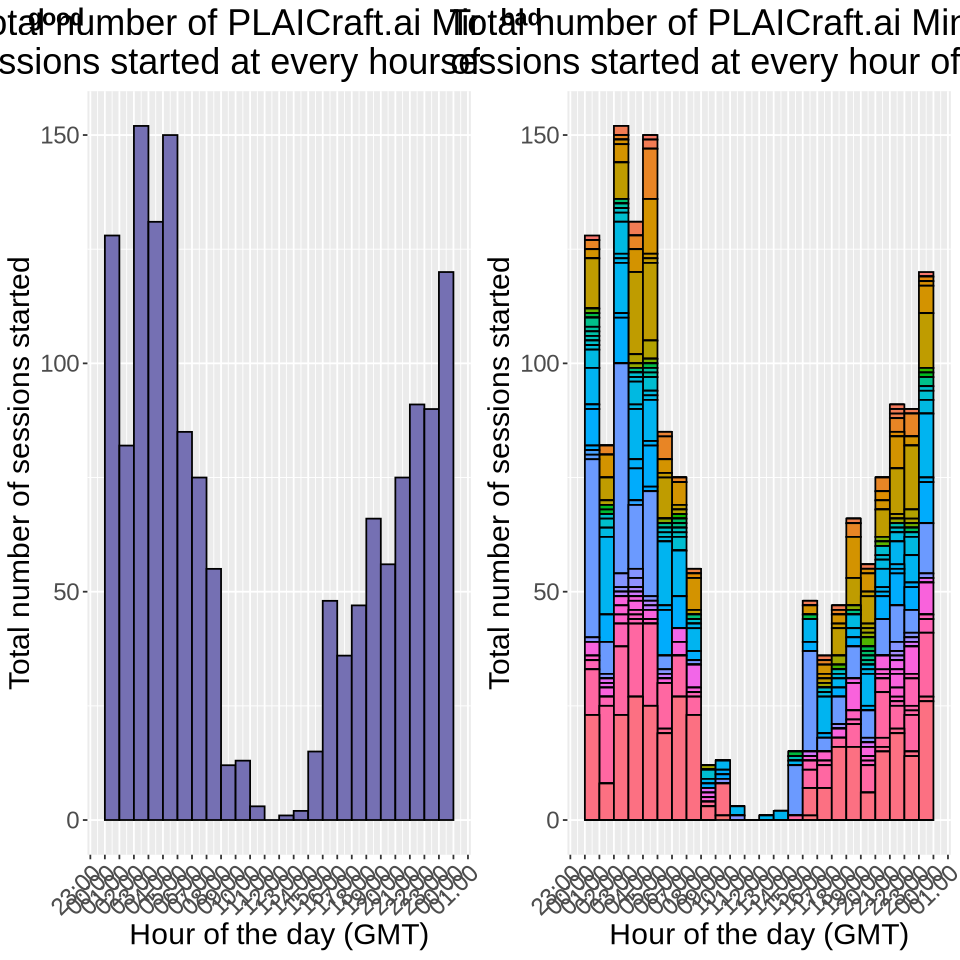

In [69]:
length(unique(sessions$hashedEmail))
plot_grid(sessions_start, sessions_start_TEST, align = "hv", nrow = 1, ncol = 2, labels = c("good", "bad"))

In [96]:
options(repr.matrix.max.rows = 10)
sessions |> group_by(hashedEmail) |> summarize(number_entries = n()) |> arrange(desc(number_entries)) |> head(10)
# can fix the problem by oversampling the players who have lower play sessions?

hashedEmail                                                     
1  fd6563a4e0f6f4273580e5fedbd8dda64990447aea5a33cbb5e894a3867ca44d
2  bfce39c89d6549f2bb94d8064d3ce69dc3d7e72b38f431d8aa0c4bf95ccee6bf
3  f8f5477f5a2e53616ae37421b1c660b971192bd8ff77e3398304c7ae42581fdc
4  ad6390295640af1ed0e45ffc58a53b2d9074b0eea694b16210addd44d7c81f83
5  36d9cbb4c6bc0c1a6911436d2da0d09ec625e43e6552f575d4acc9cf487c4686
6  b622593d2ef8b337dc554acb307d04a88114f2bf453b18fb5d2c80052aeb2319
7  24d4892c2c3ce11d3e54c3bf31ee218901cac7a2f564911d67424c8fdf0874fe
8  e74c60a92c0100e7240be56d66969db85856152b048c639331a3595f901461ae
9  18936844e06b6c7871dce06384e2d142dd86756941641ef39cf40a9967ea14e3
10 a175d4741dc84e6baf77901f6e8e0a06f54809a34e6b5211159bced346f7fb3e
   number_entries
1  310           
2  219           
3  159           
4  147           
5  130           
6   95           
7   79           
8   47           
9   41           
10  37

Originally, I'd wanted to use age and experience level to predict the time of day the player would start a game session, but I believe the computation required would be out of the scope of this course. Many players have more than one entry in sessions, which would mean 

Unless I pivot wider -> make each session unique, like session1, session2, session3, then have the rest as missing information??????


> No, I don’t think that’s necessary. you can just say you’d like to include whatever categorical variable as a predictor in your model through the use of “dummy variables”. There’s not a ton of space to write so don’t go overboard

In [88]:
sessions |>
    filter(hashedEmail == "fd6563a4e0f6f4273580e5fedbd8dda64990447aea5a33cbb5e894a3867ca44d") |> # THIS MOTHERFUCKER WHY DO YOU HAVE 310 ENTRIES
    mutate(start_time_only = strftime(start_time, "%H:%M:%S")) |>
    mutate(start_time_only = as.POSIXct(start_time_only, format = "%H:%M:%S", tz = "GMT")) |>
    summary()
# Ok so imputing missing data is no longer viable
# Maybe I just take the mean... or median? Probably the median...

sessions |>
    filter(hashedEmail == "fd6563a4e0f6f4273580e5fedbd8dda64990447aea5a33cbb5e894a3867ca44d") |> # THIS MOTHERFUCKER WHY DO YOU HAVE 310 ENTRIES
    mutate(start_time_only = strftime(start_time, "%H:%M:%S")) |>
    mutate(start_time_only = as.POSIXct(start_time_only, format = "%H:%M:%S", tz = "GMT")) |>
    arrange(start_time_only)

 hashedEmail          start_time                    
 Length:310         Min.   :2024-04-06 09:27:00.00  
 Class :character   1st Qu.:2024-06-05 00:12:45.00  
 Mode  :character   Median :2024-06-25 00:04:00.00  
                    Mean   :2024-06-22 15:31:34.65  
                    3rd Qu.:2024-07-10 17:34:45.00  
                    Max.   :2024-09-14 08:06:00.00  
    end_time                      original_start_time    
 Min.   :2024-04-06 09:31:00.00   Min.   :1712400000000  
 1st Qu.:2024-06-05 00:19:00.00   1st Qu.:1717550000000  
 Median :2024-06-25 00:10:00.00   Median :1719270000000  
 Mean   :2024-06-22 15:47:02.71   Mean   :1719070096770  
 3rd Qu.:2024-07-10 17:41:45.00   3rd Qu.:1720635000000  
 Max.   :2024-09-14 08:18:00.00   Max.   :1726300000000  
 original_end_time       start_time_only                 
 Min.   :1712400000000   Min.   :2025-11-14 00:04:00.00  
 1st Qu.:1717550000000   1st Qu.:2025-11-14 03:47:30.00  
 Median :1719275000000   Median :2025-11-14 07:02

hashedEmail                                                     
1   fd6563a4e0f6f4273580e5fedbd8dda64990447aea5a33cbb5e894a3867ca44d
2   fd6563a4e0f6f4273580e5fedbd8dda64990447aea5a33cbb5e894a3867ca44d
3   fd6563a4e0f6f4273580e5fedbd8dda64990447aea5a33cbb5e894a3867ca44d
4   fd6563a4e0f6f4273580e5fedbd8dda64990447aea5a33cbb5e894a3867ca44d
5   fd6563a4e0f6f4273580e5fedbd8dda64990447aea5a33cbb5e894a3867ca44d
6   fd6563a4e0f6f4273580e5fedbd8dda64990447aea5a33cbb5e894a3867ca44d
7   fd6563a4e0f6f4273580e5fedbd8dda64990447aea5a33cbb5e894a3867ca44d
8   fd6563a4e0f6f4273580e5fedbd8dda64990447aea5a33cbb5e894a3867ca44d
9   fd6563a4e0f6f4273580e5fedbd8dda64990447aea5a33cbb5e894a3867ca44d
10  fd6563a4e0f6f4273580e5fedbd8dda64990447aea5a33cbb5e894a3867ca44d
11  fd6563a4e0f6f4273580e5fedbd8dda64990447aea5a33cbb5e894a3867ca44d
12  fd6563a4e0f6f4273580e5fedbd8dda64990447aea5a33cbb5e894a3867ca44d
13  fd6563a4e0f6f4273580e5fedbd8dda64990447aea5a33cbb5e894a3867ca44d
14  fd6563a4e0f6f4273580e5fedbd8dda64990447aea5a33cbb5e894a3867ca44d
15  fd6563a4e0f6f4273580e5fedbd8dda64990447aea5a33cbb5e894a3867ca44d
16  fd6563a4e0f6f4273580e5fedbd8dda64990447aea5a33cbb5e894a3867ca44d
17  fd6563a4e0f6f4273580e5fedbd8dda64990447aea5a33cbb5e894a3867ca44d
18  fd6563a4e0f6f4273580e5fedbd8dda64990447aea5a33cbb5e894a3867ca44d
19  fd6563a4e0f6f4273580e5fedbd8dda64990447aea5a33cbb5e894a3867ca44d
20  fd6563a4e0f6f4273580e5fedbd8dda64990447aea5a33cbb5e894a3867ca44d
21  fd6563a4e0f6f4273580e5fedbd8dda64990447aea5a33cbb5e894a3867ca44d
22  fd6563a4e0f6f4273580e5fedbd8dda64990447aea5a33cbb5e894a3867ca44d
23  fd6563a4e0f6f4273580e5fedbd8dda64990447aea5a33cbb5e894a3867ca44d
24  fd6563a4e0f6f4273580e5fedbd8dda64990447aea5a33cbb5e894a3867ca44d
25  fd6563a4e0f6f4273580e5fedbd8dda64990447aea5a33cbb5e894a3867ca44d
26  fd6563a4e0f6f4273580e5fedbd8dda64990447aea5a33cbb5e894a3867ca44d
27  fd6563a4e0f6f4273580e5fedbd8dda64990447aea5a33cbb5e894a3867ca44d
28  fd6563a4e0f6f4273580e5fedbd8dda64990447aea5a33cbb5e894a3867ca44d
29  fd6563a4e0f6f4273580e5fedbd8dda64990447aea5a33cbb5e894a3867ca44d
30  fd6563a4e0f6f4273580e5fedbd8dda64990447aea5a33cbb5e894a3867ca44d
31  fd6563a4e0f6f4273580e5fedbd8dda64990447aea5a33cbb5e894a3867ca44d
32  fd6563a4e0f6f4273580e5fedbd8dda64990447aea5a33cbb5e894a3867ca44d
33  fd6563a4e0f6f4273580e5fedbd8dda64990447aea5a33cbb5e894a3867ca44d
34  fd6563a4e0f6f4273580e5fedbd8dda64990447aea5a33cbb5e894a3867ca44d
35  fd6563a4e0f6f4273580e5fedbd8dda64990447aea5a33cbb5e894a3867ca44d
36  fd6563a4e0f6f4273580e5fedbd8dda64990447aea5a33cbb5e894a3867ca44d
37  fd6563a4e0f6f4273580e5fedbd8dda64990447aea5a33cbb5e894a3867ca44d
38  fd6563a4e0f6f4273580e5fedbd8dda64990447aea5a33cbb5e894a3867ca44d
39  fd6563a4e0f6f4273580e5fedbd8dda64990447aea5a33cbb5e894a3867ca44d
40  fd6563a4e0f6f4273580e5fedbd8dda64990447aea5a33cbb5e894a3867ca44d
41  fd6563a4e0f6f4273580e5fedbd8dda64990447aea5a33cbb5e894a3867ca44d
42  fd6563a4e0f6f4273580e5fedbd8dda64990447aea5a33cbb5e894a3867ca44d
43  fd6563a4e0f6f4273580e5fedbd8dda64990447aea5a33cbb5e894a3867ca44d
44  fd6563a4e0f6f4273580e5fedbd8dda64990447aea5a33cbb5e894a3867ca44d
45  fd6563a4e0f6f4273580e5fedbd8dda64990447aea5a33cbb5e894a3867ca44d
46  fd6563a4e0f6f4273580e5fedbd8dda64990447aea5a33cbb5e894a3867ca44d
47  fd6563a4e0f6f4273580e5fedbd8dda64990447aea5a33cbb5e894a3867ca44d
48  fd6563a4e0f6f4273580e5fedbd8dda64990447aea5a33cbb5e894a3867ca44d
49  fd6563a4e0f6f4273580e5fedbd8dda64990447aea5a33cbb5e894a3867ca44d
50  fd6563a4e0f6f4273580e5fedbd8dda64990447aea5a33cbb5e894a3867ca44d
51  fd6563a4e0f6f4273580e5fedbd8dda64990447aea5a33cbb5e894a3867ca44d
52  fd6563a4e0f6f4273580e5fedbd8dda64990447aea5a33cbb5e894a3867ca44d
53  fd6563a4e0f6f4273580e5fedbd8dda64990447aea5a33cbb5e894a3867ca44d
54  fd6563a4e0f6f4273580e5fedbd8dda64990447aea5a33cbb5e894a3867ca44d
55  fd6563a4e0f6f4273580e5fedbd8dda64990447aea5a33cbb5e894a3867ca44d
56  fd6563a4e0f6f4273580e5fedbd8dda64990447aea5a33cbb5e894a3867ca44d
57  fd6563a4e0f6f4273580e5fedbd8dda64990447aea5a33cbb5e894a3867ca44d
58